<a href="https://colab.research.google.com/github/ramalias/urban-expansion/blob/main/04_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import rasterio
import geopandas as gpd
from rasterio import features
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from tqdm import tqdm
from rasterio.warp import reproject, Resampling
import glob
import sys

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from IPython.display import clear_output
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")

In [7]:
print("Python:", sys.executable)
print("torch.__version__:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("cuda available:", torch.cuda.is_available())

Python: /usr/bin/python3
torch.__version__: 2.9.0+cu126
torch.version.cuda: 12.6
cuda available: True


In [8]:
!nvidia-smi

Sun Dec  7 07:32:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             42W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
def load_raster(path):
    """Load raster and return array + profile."""
    src = rasterio.open(path)
    arr = src.read(1)
    profile = src.profile
    return arr, profile

def save_raster(path, array, profile):
    """Save raster with given profile."""
    profile.update(dtype=rasterio.uint8, count=1)
    with rasterio.open(path, "w", **profile) as dst:
        dst.write(array.astype("uint8"), 1)

def rasterize_shapefile(gdf, reference_profile, attribute):
    """Rasterize shapefile according to reference raster."""
    shapes = [(geom, value) for geom, value in zip(gdf.geometry, gdf[attribute])]
    raster = features.rasterize(
        shapes=shapes,
        out_shape=(reference_profile["height"], reference_profile["width"]),
        transform=reference_profile["transform"],
        fill=0,
        dtype="uint8"
    )
    return raster

# Load final data

In [15]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ValueError: Mountpoint must not already contain files

In [11]:
BASE_DIR = r"/content/drive/MyDrive/12-training-data"

# Feature rasters live directly inside BASE_DIR
FEATURE_DIR = os.path.join(BASE_DIR, "input")
FEATURE_DIR_ALIGNED_2019 = os.path.join(FEATURE_DIR, "training-data-final2019")
FEATURE_DIR_ALIGNED_2024 = os.path.join(FEATURE_DIR, "2024-data")

DEPENDENT_DIR = os.path.join(FEATURE_DIR, "dependent-data-urban-no")
LANDCOVER_DIR = os.path.join(FEATURE_DIR, "final-data-land-cover")

In [12]:
print(FEATURE_DIR)
print(FEATURE_DIR_ALIGNED_2019)
print(FEATURE_DIR_ALIGNED_2024)

/content/drive/MyDrive/12-training-data/input
/content/drive/MyDrive/12-training-data/input/training-data-final2019
/content/drive/MyDrive/12-training-data/input/2024-data


## 2019 data

In [8]:
rasters_2019 = {
    "NDVI": os.path.join(FEATURE_DIR, "NDVI_2019.tif"),
    "NDBI": os.path.join(FEATURE_DIR, "NDBI_2019.tif"),
    "MNDWI": os.path.join(FEATURE_DIR, "MNDWI_2019.tif"),
    "BSI": os.path.join(FEATURE_DIR, "BSI_2019.tif"),
    "DEM": os.path.join(FEATURE_DIR, "DEM-DAegu-merged-clipmask.tif"),
    "slope": os.path.join(FEATURE_DIR, "slope.tif"),
    "aspect": os.path.join(FEATURE_DIR, "aspect.tif"),
    "hillshade": os.path.join(FEATURE_DIR, "hillshade.tif"),
    "night": os.path.join(FEATURE_DIR, "VNL_2019_daegu_clipped.tif"),
    "ecology": os.path.join(FEATURE_DIR, "env-assessment-data-2019.tif"),
}

In [9]:
feature_arrays_2019 = {}
feature_profiles = {}

print("Loading 2019 rasters...\n")

for name, path in rasters_2019.items():
    arr, profile = load_raster(path)
    feature_arrays_2019[name] = arr
    feature_profiles[name] = profile
    print(f"{name} loaded → shape: {arr.shape}")

Loading 2019 rasters...

NDVI loaded → shape: (4531, 3714)
NDBI loaded → shape: (4531, 3714)
MNDWI loaded → shape: (4531, 3714)
BSI loaded → shape: (4531, 3714)
DEM loaded → shape: (1622, 1330)
slope loaded → shape: (1622, 1330)
aspect loaded → shape: (1622, 1330)
hillshade loaded → shape: (1622, 1330)
night loaded → shape: (99, 100)
ecology loaded → shape: (4590, 3684)


In [10]:
aligned_arrays_2019 = {
    "NDVI": rasters_2019["NDVI"],     # Use original path
    "NDBI": rasters_2019["NDBI"],
    "MNDWI": rasters_2019["MNDWI"],
    "BSI": rasters_2019["BSI"],

    "DEM": os.path.join(FEATURE_DIR_ALIGNED_2019, "DEM_aligned.tif"),
    "slope": os.path.join(FEATURE_DIR_ALIGNED_2019, "slope_aligned.tif"),
    "aspect": os.path.join(FEATURE_DIR_ALIGNED_2019, "aspect_aligned.tif"),
    "hillshade": os.path.join(FEATURE_DIR_ALIGNED_2019, "hillshade_aligned.tif"),
    "night": os.path.join(FEATURE_DIR_ALIGNED_2019, "night_aligned.tif"),
    "ecology": os.path.join(FEATURE_DIR_ALIGNED_2019, "ecology_aligned.tif"),
}

In [11]:
feature_align_arrays_2019 = {}
feature_profiles = {}

print("Loading aligned raster data...\n")

for name, path in aligned_arrays_2019.items():
    arr, profile = load_raster(path)
    feature_align_arrays_2019[name] = arr
    feature_profiles[name] = profile
    print(f"{name} loaded → shape: {arr.shape}")

Loading aligned raster data...

NDVI loaded → shape: (4531, 3714)
NDBI loaded → shape: (4531, 3714)
MNDWI loaded → shape: (4531, 3714)
BSI loaded → shape: (4531, 3714)
DEM loaded → shape: (4531, 3714)
slope loaded → shape: (4531, 3714)
aspect loaded → shape: (4531, 3714)
hillshade loaded → shape: (4531, 3714)
night loaded → shape: (4531, 3714)
ecology loaded → shape: (4531, 3714)


In [12]:
reference_profile = feature_profiles["NDVI"]
ref_crs = reference_profile["crs"]
ref_res = reference_profile["transform"][0]
ref_width, ref_height = reference_profile["width"], reference_profile["height"]
ref_bounds = rasterio.open(rasters_2019["NDVI"]).bounds

print("REFERENCE NDVI:")
print("  CRS:", ref_crs)
print("  Res:", ref_res)
print("  Size:", ref_height, "x", ref_width)
print("  Bounds:", ref_bounds)
print("--------------------------------------------------")

for name, path in aligned_arrays_2019.items():
    with rasterio.open(path) as src:
        print(f"Raster: {name}")
        print("  CRS:", src.crs)
        print("  Res:", src.res)
        print("  Size:", src.height, "x", src.width)
        print("  Bounds:", src.bounds)
        print("  SAME CRS?", src.crs == ref_crs)
        print("  SAME RES?", src.res[0] == ref_res)
        print("  SAME SIZE?", (src.height == ref_height) and (src.width == ref_width))
        print("--------------------------------------------------")

REFERENCE NDVI:
  CRS: EPSG:32652
  Res: 10.0
  Size: 4531 x 3714
  Bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
--------------------------------------------------
Raster: NDVI
  CRS: EPSG:32652
  Res: (10.0, 10.0)
  Size: 4531 x 3714
  Bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
  SAME CRS? True
  SAME RES? True
  SAME SIZE? True
--------------------------------------------------
Raster: NDBI
  CRS: EPSG:32652
  Res: (10.0, 10.0)
  Size: 4531 x 3714
  Bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
  SAME CRS? True
  SAME RES? True
  SAME SIZE? True
--------------------------------------------------
Raster: MNDWI
  CRS: EPSG:32652
  Res: (10.0, 10.0)
  Size: 4531 x 3714
  Bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
  SAME CRS? True
  SAME RES? True
  SAME SIZE? True
--------------------------------------------------
Raster: BSI
  CR

#2024 data

In [13]:
rasters_2024 = {
    "NDVI": os.path.join(FEATURE_DIR_ALIGNED_2024, "NDVI_2024.tif"),
    "NDBI": os.path.join(FEATURE_DIR_ALIGNED_2024, "NDBI_2024.tif"),
    "MNDWI": os.path.join(FEATURE_DIR_ALIGNED_2024, "MNDWI_2024.tif"),
    "BSI": os.path.join(FEATURE_DIR_ALIGNED_2024, "BSI_2024.tif"),
    "DEM": os.path.join(FEATURE_DIR, "DEM-DAegu-merged-clipmask.tif"),
    "slope": os.path.join(FEATURE_DIR_ALIGNED_2024, "slope.tif"),
    "aspect": os.path.join(FEATURE_DIR_ALIGNED_2024, "aspect.tif"),
    "hillshade": os.path.join(FEATURE_DIR_ALIGNED_2024, "hillshade.tif"),
    "night": os.path.join(FEATURE_DIR_ALIGNED_2024, "VNL_2024_daegu_clipped.tif"),
    "ecology": os.path.join(FEATURE_DIR_ALIGNED_2024, "env-assessment-data-2024.tif"),
}

In [14]:
feature_arrays_2024 = {}
feature_profiles = {}

print("Loading 2024 rasters...\n")

for name, path in rasters_2024.items():
    arr, profile = load_raster(path)
    feature_arrays_2024[name] = arr
    feature_profiles[name] = profile
    print(f"{name} loaded → shape: {arr.shape}")

Loading 2024 rasters...

NDVI loaded → shape: (4531, 3714)
NDBI loaded → shape: (4531, 3714)
MNDWI loaded → shape: (4531, 3714)
BSI loaded → shape: (4531, 3714)
DEM loaded → shape: (1622, 1330)
slope loaded → shape: (1622, 1330)
aspect loaded → shape: (1622, 1330)
hillshade loaded → shape: (1622, 1330)
night loaded → shape: (99, 100)
ecology loaded → shape: (9180, 7368)


In [15]:
aligned_arrays_2024 = {
    "NDVI": rasters_2024["NDVI"],     # Use original path
    "NDBI": rasters_2024["NDBI"],
    "MNDWI": rasters_2024["MNDWI"],
    "BSI": rasters_2024["BSI"],

    "DEM": os.path.join(FEATURE_DIR_ALIGNED_2024, "DEM_aligned.tif"),
    "slope": os.path.join(FEATURE_DIR_ALIGNED_2024, "slope_aligned.tif"),
    "aspect": os.path.join(FEATURE_DIR_ALIGNED_2024, "aspect_aligned.tif"),
    "hillshade": os.path.join(FEATURE_DIR_ALIGNED_2024, "hillshade_aligned.tif"),
    "night": os.path.join(FEATURE_DIR_ALIGNED_2024, "night_aligned.tif"),
    "ecology": os.path.join(FEATURE_DIR_ALIGNED_2024, "ecology_aligned.tif"),
}

In [16]:
feature_align_arrays_2024 = {}
feature_profiles = {}

print("Loading aligned data 2024...\n")

for name, path in aligned_arrays_2024.items():
    arr, profile = load_raster(path)
    feature_align_arrays_2024[name] = arr
    feature_profiles[name] = profile
    print(f"{name} loaded → shape: {arr.shape}")

Loading aligned data 2024...

NDVI loaded → shape: (4531, 3714)
NDBI loaded → shape: (4531, 3714)
MNDWI loaded → shape: (4531, 3714)
BSI loaded → shape: (4531, 3714)
DEM loaded → shape: (4531, 3714)
slope loaded → shape: (4531, 3714)
aspect loaded → shape: (4531, 3714)
hillshade loaded → shape: (4531, 3714)
night loaded → shape: (4531, 3714)
ecology loaded → shape: (4531, 3714)


In [17]:
reference_profile = feature_profiles["NDVI"]
ref_crs = reference_profile["crs"]
ref_res = reference_profile["transform"][0]
ref_width, ref_height = reference_profile["width"], reference_profile["height"]
ref_bounds = rasterio.open(rasters_2019["NDVI"]).bounds

print("REFERENCE NDVI:")
print("  CRS:", ref_crs)
print("  Res:", ref_res)
print("  Size:", ref_height, "x", ref_width)
print("  Bounds:", ref_bounds)
print("--------------------------------------------------")

for name, path in aligned_arrays_2024.items():
    with rasterio.open(path) as src:
        print(f"Raster: {name}")
        print("  CRS:", src.crs)
        print("  Res:", src.res)
        print("  Size:", src.height, "x", src.width)
        print("  Bounds:", src.bounds)
        print("  SAME CRS?", src.crs == ref_crs)
        print("  SAME RES?", src.res[0] == ref_res)
        print("  SAME SIZE?", (src.height == ref_height) and (src.width == ref_width))
        print("--------------------------------------------------")

REFERENCE NDVI:
  CRS: EPSG:32652
  Res: 10.0
  Size: 4531 x 3714
  Bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
--------------------------------------------------
Raster: NDVI
  CRS: EPSG:32652
  Res: (10.0, 10.0)
  Size: 4531 x 3714
  Bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
  SAME CRS? True
  SAME RES? True
  SAME SIZE? True
--------------------------------------------------
Raster: NDBI
  CRS: EPSG:32652
  Res: (10.0, 10.0)
  Size: 4531 x 3714
  Bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
  SAME CRS? True
  SAME RES? True
  SAME SIZE? True
--------------------------------------------------
Raster: MNDWI
  CRS: EPSG:32652
  Res: (10.0, 10.0)
  Size: 4531 x 3714
  Bounds: BoundingBox(left=441320.0, bottom=3940480.0, right=478460.0, top=3985790.0)
  SAME CRS? True
  SAME RES? True
  SAME SIZE? True
--------------------------------------------------
Raster: BSI
  CR

# urban classification

In [18]:
# Paths
urban19_path = os.path.join(DEPENDENT_DIR, "urban_2019.tif")
urban24_path = os.path.join(DEPENDENT_DIR, "urban_2024.tif")

# Load both rasters
with rasterio.open(urban19_path) as src19:
    u19 = src19.read(1)
    profile = src19.profile

with rasterio.open(urban24_path) as src24:
    u24 = src24.read(1)

# Create output label array
label = np.zeros_like(u19, dtype=np.uint8)

# 1 = became urban (2019 nonurban → 2024 urban)
label[(u19 == 0) & (u24 == 1)] = 1

# 0 = stayed nonurban (2019 nonurban → 2024 nonurban)
label[(u19 == 0) & (u24 == 0)] = 0

# 255 = ignore (urban already in 2019, or urban→nonurban)
label[(u19 == 1)] = 255

# Save output
profile.update(dtype=rasterio.uint8, nodata=255)

output_path = os.path.join(DEPENDENT_DIR, "urban_no_urban.tif")
with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(label, 1)

print("Saved:", output_path)


Saved: /content/drive/MyDrive/12-training-data/input/dependent-data-urban-no/urban_no_urban.tif


In [19]:
unique, counts = np.unique(label, return_counts=True)
print(list(zip(unique, counts)))

[(np.uint8(0), np.int64(14286520)), (np.uint8(1), np.int64(265903)), (np.uint8(255), np.int64(2275711))]


# Stacked Array

In [20]:
# normalization
def normalize(arr):
    """Min-max normalize array to 0–1."""
    arr = arr.astype(np.float32)
    mn, mx = np.nanmin(arr), np.nanmax(arr)
    if mx - mn == 0:
        return np.zeros_like(arr)
    return (arr - mn) / (mx - mn)

#normalize all aligned feature
normalized_features = {}
for name, arr in feature_align_arrays_2019.items():
    norm_arr = normalize(arr)
    normalized_features[name] = norm_arr
    print(f"{name:12} normalized → min={norm_arr.min():.3f}, max={norm_arr.max():.3f}")

print("\nAll features normalized.\n")

# load dependent label raster (urban/no urban)
label_path = os.path.join(DEPENDENT_DIR, "urban_no_urban.tif")

with rasterio.open(label_path) as src:
    y = src.read(1)
    label_nodata = src.nodata
    print("Label shape:", y.shape)
    print("Label nodata:", label_nodata)

# Create valid mask (True = usable pixel)
if label_nodata is None:
    label_mask = np.ones_like(y, dtype=bool)
else:
    label_mask = (y != label_nodata)

# ----------------------------------------------------
# 4. STACK FEATURES INTO X (H, W, C)
# ----------------------------------------------------
feature_list = []
feature_names = []

for name, arr in normalized_features.items():
    feature_list.append(arr)
    feature_names.append(name)

# Stack: output shape (H, W, C)
X = np.stack(feature_list, axis=-1)

print("\n====================")
print("STACKED ARRAY READY!")
print("====================")
print("X shape:", X.shape)         # (H, W, C)
print("y shape:", y.shape)         # (H, W)
print("Feature order:", feature_names)

NDVI         normalized → min=0.000, max=1.000
NDBI         normalized → min=0.000, max=1.000
MNDWI        normalized → min=0.000, max=1.000
BSI          normalized → min=0.000, max=1.000
DEM          normalized → min=0.000, max=1.000
slope        normalized → min=0.000, max=1.000
aspect       normalized → min=0.000, max=1.000
hillshade    normalized → min=0.000, max=1.000
night        normalized → min=0.000, max=1.000
ecology      normalized → min=0.000, max=1.000

All features normalized.

Label shape: (4531, 3714)
Label nodata: 255.0

STACKED ARRAY READY!
X shape: (4531, 3714, 10)
y shape: (4531, 3714)
Feature order: ['NDVI', 'NDBI', 'MNDWI', 'BSI', 'DEM', 'slope', 'aspect', 'hillshade', 'night', 'ecology']


# Patch Extraction Code


In [6]:
BASE_DIR = r"/content/drive/MyDrive/12-training-data"
PATCH_DIR = os.path.join(BASE_DIR, "patches")   # PATCH_SIZE = 64
PATCH_SIZE = 64
BATCH_SIZE = 8
EPOCHS = 150

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

NUM_FEATURE_BANDS = 10
MODEL_OUT = os.path.join(BASE_DIR, "models_150")
os.makedirs(MODEL_OUT, exist_ok=True)

DEVICE: cuda


run only when want to extract

In [22]:
PATCH_SIZE = 64
STRIDE = 32

X = X
y = y

# Clear existing patches to ensure consistency
import shutil
if os.path.exists(PATCH_DIR):
    shutil.rmtree(PATCH_DIR)
print(f"Cleared existing patches in {PATCH_DIR}")

# Where to save patches
os.makedirs(PATCH_DIR, exist_ok=True)
os.makedirs(os.path.join(PATCH_DIR, "X"), exist_ok=True)
os.makedirs(os.path.join(PATCH_DIR, "y"), exist_ok=True)

h, w, c = X.shape
print("Raster size:", h, w)
print("Channels:", c)

patch_id = 0

for row in tqdm(range(0, h - PATCH_SIZE, STRIDE)):
    for col in range(0, w - PATCH_SIZE, STRIDE):

        X_patch = X[row:row+PATCH_SIZE, col:col+PATCH_SIZE, :]
        y_patch = y[row:row+PATCH_SIZE, col:col+PATCH_SIZE]

        # Skip patches where all labels are 255
        if np.all(y_patch == 255):
            continue

        # Optional: keep all patches that contain ANY urbanization (label=1)
        # This improves class balance
        if (1 in y_patch):
            pass  # keep
        else:
            # Keep only 20% of negative patches (random sampling)
            if np.random.rand() > 0.20:
                continue

        # Save patch
        np.save(os.path.join(PATCH_DIR, "X", f"X_{patch_id}.npy"), X_patch)
        np.save(os.path.join(PATCH_DIR, "y", f"y_{patch_id}.npy"), y_patch)

        patch_id += 1

print("Total patches saved:", patch_id)

Cleared existing patches in /content/drive/MyDrive/12-training-data/patches
Raster size: 4531 3714
Channels: 10


100%|██████████| 140/140 [02:42<00:00,  1.16s/it]

Total patches saved: 10849


# Training

2019 data -- feature (independent)

NDVI, NDBI, MNDWI, BSI, ecology (env assessment data), lightime data

urban change data (2024 - 2019) -- label (dependent)

In [23]:
class PatchDataset(Dataset):
    def __init__(self, x_files, y_files, augment=True):
        self.x_files = x_files
        self.y_files = y_files
        self.augment = augment

    def __len__(self):
        return len(self.x_files)

    def __getitem__(self, idx):
        x = np.load(self.x_files[idx]).astype(np.float32)      # (H, W, C)
        y = np.load(self.y_files[idx]).astype(np.uint8)        # (H, W)

        # Add assertion to check patch dimensions
        assert x.shape[0] == PATCH_SIZE and x.shape[1] == PATCH_SIZE, \
            f"X patch size mismatch: Expected ({PATCH_SIZE}, {PATCH_SIZE}), got {x.shape[:2]} for {self.x_files[idx]}"
        assert y.shape[0] == PATCH_SIZE and y.shape[1] == PATCH_SIZE, \
            f"Y patch size mismatch: Expected ({PATCH_SIZE}, {PATCH_SIZE}), got {y.shape} for {self.y_files[idx]}"

        x = torch.from_numpy(x).permute(2, 0, 1)               # -> (C, H, W)
        y = torch.from_numpy(y).float().unsqueeze(0)           # -> (1, H, W)

        # clamp ignore 255 → 0 because DL expects 0/1
        y = torch.clamp(y, 0, 1)

        if self.augment:
            x, y = self._augment(x, y)

        return x, y

    def _augment(self, x, y):
        if np.random.rand() > 0.5:
            x = TF.hflip(x); y = TF.hflip(y)
        if np.random.rand() > 0.5:
            x = TF.vflip(x); y = TF.vflip(y)
        k = np.random.randint(4)
        if k:
            x = torch.rot90(x, k, [1,2])
            y = torch.rot90(y, k, [1,2])
        return x, y

In [3]:
# -----------------------
# UNet Model
# -----------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=9, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Downsampling layers
        for feat in features:
            self.downs.append(ConvBlock(in_channels, feat))
            in_channels = feat

        # Bottleneck
        self.bottleneck = ConvBlock(features[-1], features[-1]*2)

        # Upsampling layers
        for feat in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feat*2, feat, kernel_size=2, stride=2))
            self.ups.append(ConvBlock(feat*2, feat))

        self.pool = nn.MaxPool2d(2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Down path
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Up path
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip = skip_connections[idx//2]
            if x.shape != skip.shape:
                skip = TF.center_crop(skip, (x.shape[2], x.shape[3]))
            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx+1](x)

        return self.final_conv(x)

In [25]:
# -----------------------
# LOSS FUNCTIONS
# -----------------------
def dice_loss(pred, target, eps=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    return 1 - (2*intersection + eps) / (union + eps)


class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        loss_bce = self.bce(logits, targets)
        loss_dice = dice_loss(logits, targets)
        return loss_bce + loss_dice

In [26]:
# -----------------------
# LOAD PATCHES
# -----------------------
x_files = sorted(glob.glob(os.path.join(PATCH_DIR, "X", "*.npy")))
y_files = sorted(glob.glob(os.path.join(PATCH_DIR, "y", "*.npy")))

print("Total patches found:", len(x_files))

train_x, val_x, train_y, val_y = train_test_split(
    x_files, y_files, test_size=0.10, random_state=42
)

train_ds = PatchDataset(train_x, train_y, augment=True)
val_ds   = PatchDataset(val_x, val_y, augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}")

Total patches found: 10849
Train: 9764, Val: 1085


In [5]:
# -----------------------
# TRAINING SETUP
# -----------------------
model = UNet(in_channels=NUM_FEATURE_BANDS).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = BCEDiceLoss()

best_f1 = 0.0

NameError: name 'NUM_FEATURE_BANDS' is not defined

In [28]:
history = {
    "train_loss": [],
    "val_loss": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "accuracy": []
}


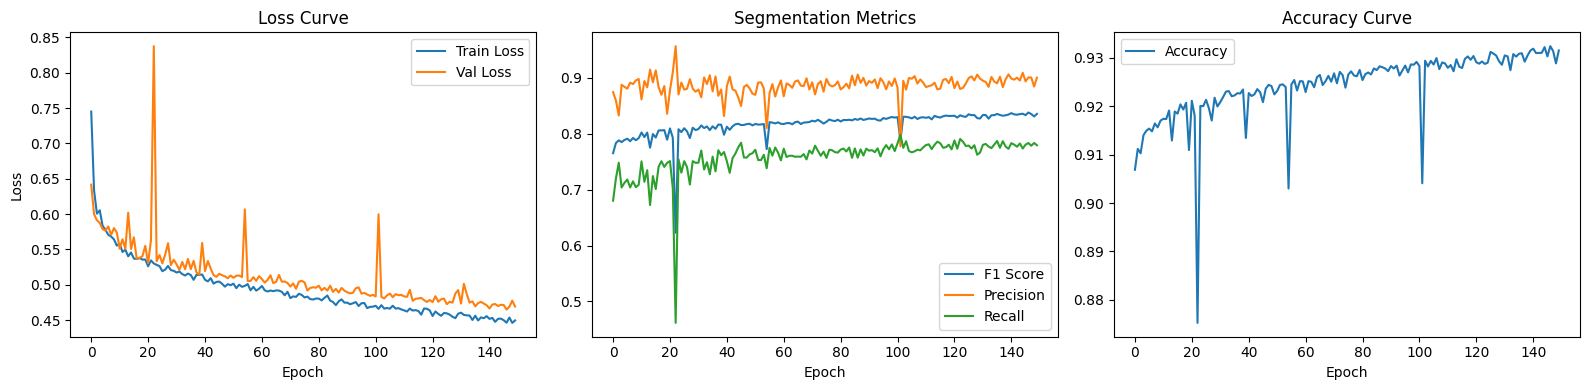

Epoch 150 | Train Loss: 0.4496 | Val Loss: 0.4693 | P: 0.900 R: 0.779 F1: 0.835 Acc: 0.932
Training finished. Best F1: 0.8380000556066732


In [29]:
# -----------------------
# TRAINING LOOP
# -----------------------
def threshold_logits(logits, thresh=0.5):
    return (torch.sigmoid(logits) > thresh).float()

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}"):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_ds)

    # -----------------------
    # VALIDATION
    # -----------------------
    model.eval()
    val_loss = 0
    tp=fp=fn=tn=0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)

            preds = threshold_logits(logits)

            # Flatten
            preds_f = preds.view(-1)
            yb_f = yb.view(-1)

            tp += ((preds_f==1) & (yb_f==1)).sum().item()
            tn += ((preds_f==0) & (yb_f==0)).sum().item()
            fp += ((preds_f==1) & (yb_f==0)).sum().item()
            fn += ((preds_f==0) & (yb_f==1)).sum().item()

    val_loss /= len(val_ds)
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)
    acc       = (tp + tn) / (tp + tn + fp + fn + 1e-9)

    # -----------------------
    # STORE METRICS
    # -----------------------
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["precision"].append(precision)
    history["recall"].append(recall)
    history["f1"].append(f1)
    history["accuracy"].append(acc)

    # -----------------------
    # LIVE PLOTTING
    # -----------------------
    clear_output(wait=True)
    plt.figure(figsize=(16,4))

    # LOSS CURVE
    plt.subplot(1, 3, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # F1 / PRECISION / RECALL
    plt.subplot(1, 3, 2)
    plt.plot(history["f1"], label="F1 Score")
    plt.plot(history["precision"], label="Precision")
    plt.plot(history["recall"], label="Recall")
    plt.title("Segmentation Metrics")
    plt.xlabel("Epoch")
    plt.legend()

    # ACCURACY
    plt.subplot(1, 3, 3)
    plt.plot(history["accuracy"], label="Accuracy")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"P: {precision:.3f} R: {recall:.3f} F1: {f1:.3f} Acc: {acc:.3f}")

    # Save best model
    if f1 > best_f1:
        best_f1 = f1
        ckpt = os.path.join(MODEL_OUT, f"unet_best_f1_{best_f1:.4f}.pth")
        torch.save(model.state_dict(), ckpt)
        print("Saved:", ckpt)

print("Training finished. Best F1:", best_f1)

In [30]:
ckpts = sorted(glob.glob(os.path.join(MODEL_OUT, "*.pth")))
ckpts

['/content/drive/MyDrive/12-training-data/models_150/unet_best_f1_0.7652.pth',
 '/content/drive/MyDrive/12-training-data/models_150/unet_best_f1_0.7834.pth',
 '/content/drive/MyDrive/12-training-data/models_150/unet_best_f1_0.7882.pth',
 '/content/drive/MyDrive/12-training-data/models_150/unet_best_f1_0.7889.pth',
 '/content/drive/MyDrive/12-training-data/models_150/unet_best_f1_0.7911.pth',
 '/content/drive/MyDrive/12-training-data/models_150/unet_best_f1_0.7924.pth',
 '/content/drive/MyDrive/12-training-data/models_150/unet_best_f1_0.8022.pth',
 '/content/drive/MyDrive/12-training-data/models_150/unet_best_f1_0.8060.pth',
 '/content/drive/MyDrive/12-training-data/models_150/unet_best_f1_0.8065.pth',
 '/content/drive/MyDrive/12-training-data/models_150/unet_best_f1_0.8095.pth',
 '/content/drive/MyDrive/12-training-data/models_150/unet_best_f1_0.8099.pth',
 '/content/drive/MyDrive/12-training-data/models_150/unet_best_f1_0.8107.pth',
 '/content/drive/MyDrive/12-training-data/models_150

# Full Raster Inference

In [13]:
MODEL_PATH = "/content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8232.pth"
DEVICE = torch.device("cuda")

# Load model
model = UNet(in_channels=NUM_FEATURE_BANDS).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

print("Model loaded")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/12-training-data/models/unet_best_f1_0.8232.pth'

In [ ]:
X.shape = (4531, 3714, 9)

In [ ]:
H, W, C = X.shape
PATCH_SIZE = 64
STRIDE = 32

prob_map = np.zeros((H, W), dtype=np.float32)
count_map = np.zeros((H, W), dtype=np.float32)

for row in tqdm(range(0, H - PATCH_SIZE + 1, STRIDE)):
    for col in range(0, W - PATCH_SIZE + 1, STRIDE):

        patch = X[row:row+PATCH_SIZE, col:col+PATCH_SIZE, :]
        patch_t = torch.from_numpy(patch).permute(2,0,1).unsqueeze(0).float().to(DEVICE)

        with torch.no_grad():
            logits = model(patch_t)
            probs = torch.sigmoid(logits).cpu().numpy()[0,0]

        prob_map[row:row+PATCH_SIZE, col:col+PATCH_SIZE] += probs
        count_map[row:row+PATCH_SIZE, col:col+PATCH_SIZE] += 1

In [ ]:
count_map[count_map == 0] = 1
final_prob_map = prob_map / count_map

In [ ]:
ref_path = rasters_2019["NDVI"]

with rasterio.open(ref_path) as src:
    ref_profile = src.profile

ref_profile.update(
    dtype=rasterio.float32,
    count=1,
    compress="lzw"
)

# Ensure the output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

out_path = os.path.join(OUTPUT_DIR, "urbanization_probability_2024.tif")

with rasterio.open(out_path, "w", **ref_profile) as dst:
    dst.write(final_prob_map.astype(np.float32), 1)

print("Saved:", out_path)

In [ ]:
prob_path = "/content/drive/MyDrive/12-training-data/output/urbanization_probability_2024.tif"

with rasterio.open(prob_path) as src:
    prob = src.read(1)
    print("Shape:", prob.shape)
    print("Min:", np.min(prob), "Max:", np.max(prob))

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(prob, cmap='viridis', vmin=0, vmax=1)
plt.colorbar(label="Urbanization Probability (2019→2024)")
plt.title("Urbanization Probability Map")
plt.axis("off")
plt.show()

In [ ]:
urban2024_path = "/content/drive/MyDrive/12-training-data/input/dependent-data-urban-no/urban_2024.tif"

with rasterio.open(urban2024_path) as src:
    urban24 = src.read(1)

plt.figure(figsize=(12, 12))
plt.subplot(1,2,1)
plt.imshow(prob, cmap='gray', vmin=0, vmax=1)
plt.title("Predicted Probability")

plt.subplot(1,2,2)
plt.imshow(urban24, cmap='gray')
plt.title("Actual Urban 2024")

plt.show()

# Predict 2029

In [ ]:
# compute and save 2019 min-max scalers
scalers = {}
for name, arr in feature_align_arrays_2019.items():
    mn, mx = np.nanmin(arr), np.nanmax(arr)
    scalers[name] = (mn, mx)
np.save("/content/drive/MyDrive/12-training-data/output/2019_scalers.npy", scalers)
print("Saved 2019 scalers!")